In [1]:
import pandas as pd
import numpy as np 
import os 
from fastai.text import *

In [2]:
train_df = pd.read_csv('../data/toxic_comment/cleaned/train.csv')
test_df = pd.read_csv('../data/toxic_comment/cleaned/test.csv')

In [3]:
test_df.head()

,Unnamed: 0,id,comment_text
0,0,00001cee341fdb12,yo bitch ja rule is more succesful then youll ...
1,1,0000247867823ef7,from rfc the title is fine as it is imo
2,2,00013b17ad220c46,sources zawe ashton on lapland
3,3,00017563c3f7919a,if you have a look back at the source the info...
4,4,00017695ad8997eb,i do not anonymously edit articles at all


In [4]:
train_df.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0000997932d777bf,explanation why the edit is made under my user...,0,0,0,0,0,0
1,1,000103f0d9cfb60f,daww he matches this background colour i am se...,0,0,0,0,0,0
2,2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0
3,3,0001b41b1c6bb37e,more i can not make any real suggestions on im...,0,0,0,0,0,0
4,4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


In [5]:
train_df['comment_text'].fillna('no comment', inplace=True)

In [6]:
data = (TextList.from_df(train_df, cols='comment_text')
                .split_by_rand_pct(0.2)
                .label_for_lm()  
                .databunch(bs=48))
data.show_batch()

idx,text
0,a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if noone else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i
1,croatia the article is not objective and i think objectivity is important one harmless example of that is presenting banknote of serbia with his image and not presenting the croatian one apparently this wiki page is edited by serbian wiki page and that is why it is not objective i suggest that the page should be edited by another wiki project that is how we will stop counting teslas blood
2,provisions for you have to earn xxunk c w xxbos we might want to consider redirecting it to health applications and clinical studies of meditation meditation therapy seems to be an uncommon term in clinical applications and does not in my mind deserve an article i am somewhat familiar with research on health applications of mediation and i have never seen that term used if you do a search on
3,is a wise one or not is not for me to support or deny and yes editing to include original research without providing supporting reasons can reasonable be called vandalism xxbos please refrain from censoring my comments on talk pages it is definitely not in the spirit of wikipedia xxbos thanks for the appreciation the xxunk tool used for doing the caffeine images is now available first alpha release of
4,explosive when dry xxunk now links to the list via these redirects and the redirect titles come up on the tooltip that way you get your tooltip and i get xxunk i hope this makes sense to you if ever you chem guys get around to creating separate articles on each rphrase and i think you could with expanded information on the nature of the hazard standards for storage transport


In [7]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

In [8]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


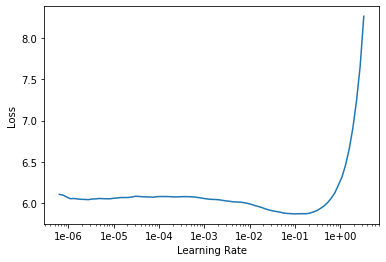

In [9]:
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8 ,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.928586,4.681971,0.244042,09:19


In [11]:
learn.save_encoder('fine_tuned_enc')

In [12]:
label_columns = ['toxic', 'severe_toxic' , 'obscene' , 'threat' , 'insult' , 'identity_hate']

In [13]:
test_df.fillna('no comment', inplace=True)
train_df.fillna('no comment', inplace=True)
test_datalist = TextList.from_df(test_df, cols='comment_text', vocab=data.vocab)

data_clas = (TextList.from_df(train_df, cols='comment_text', vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols= label_columns , classes=label_columns)
             .add_test(test_datalist)
             .databunch(bs=32))

data_clas.show_batch()

text,target
xxbos do go fuck off bastard do yyou have a life go fuck off bastard and yank your cock through your as i hate you and hope you go away forever lame is you fuck your mom die die die and all that crap this is for xxunk xxunk as i ass i as i ass i as i ass i as i ass i as i ass i as,toxic;severe_toxic;obscene;threat;insult
xxbos hey i like jews hey i like jews hey i like jews hey i like jews hey i like jews hey i like jews hey i like jews hey i like jews hey i like jews hey i like jews hey i like jews hey i like jews hey i like jews hey i like jews hey i like jews hey i like jews hey i like jews hey,
xxbos wikipedia search warrior your a dickhead your a dickhead your a dickhead your a dickhead your a dickhead your a dickhead your a dickhead your a dickhead your a dickhead your a dickhead your a dickhead your a dickhead your a dickhead your a dickhead your a dickhead your a dickhead your a dickhead your a dickhead your a dickhead your a dickhead your a dickhead your a dickhead,toxic;obscene;insult
xxbos up martinez decided to law low from the city for a while but eventually came back to mess with vics woman louise since the failed deal the vance brothers were forced to do business with the mendez brothers this was around the time the vances built their own organization in power taking over businesses from rival gangs victor did help with a transgender get things straight and met phil,
xxbos recent prooves of xxunk being made and of the corruption of the admi question from bishonen an injunction for xal oops i did not realize that the bogdanov affair affair had made it to rfar i just blocked xal for the third time for unrepentant personal attacks hours should i unblock her so she can respond to this rfar i would appreciate it if she could get an injunction,


In [14]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_classifier.load_encoder('fine_tuned_enc')
learn_classifier.freeze()

In [15]:
learn_classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


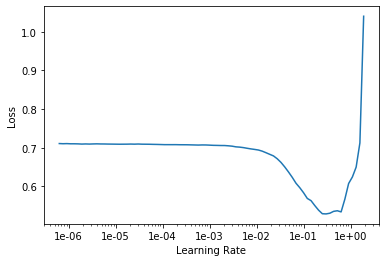

In [16]:
learn_classifier.recorder.plot()

In [17]:
learn_classifier.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,time
0,0.096469,0.092728,03:35


In [18]:
learn_classifier.freeze_to(-1)
learn_classifier.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.089562,0.069263,03:24


In [19]:
learn_classifier.freeze_to(-3)
learn_classifier.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.055854,0.049127,06:05


In [21]:
learn_classifier.show_results()

text,target,prediction
xxbos xxrep 5 f xxrep 6 u xxrep 6 c xxrep 6 k you f uu c kk you xxrep 5 f xxrep 6 u xxrep 6 c xxrep 6 k you f uu c kk you xxrep 5 f xxrep 6 u xxrep 6 c xxrep 6 k you f uu c kk you xxrep 5 f xxrep 6 u xxrep 6 c xxrep 6 k you f uu,toxic;severe_toxic;obscene;insult,toxic;insult
xxbos die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die,toxic,toxic;severe_toxic;obscene;threat;insult;identity_hate
xxbos suck my cock d suck my cock d suck my cock d suck my cock d suck my cock d suck my cock d suck my cock d suck my cock d suck my cock d suck my cock d suck my cock d suck my cock d suck my cock d suck my cock d suck my cock d suck my cock d suck my cock d suck,toxic;severe_toxic;obscene;insult,toxic;severe_toxic;obscene;insult
xxbos fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck you fuck,toxic;severe_toxic;obscene;insult,toxic;severe_toxic;obscene;insult
xxbos so i was all like who farted than i realized i need to be banned so i was all like who farted than i realized i need to be banned so i was all like who farted than i realized i need to be banned so i was all like who farted than i realized i need to be banned so i was all like who farted than i,toxic,


In [22]:
learn_classifier.export()

# Inference

In [24]:
model = load_learner('./')

In [25]:
model

RNNLearner(data=TextClasDataBunch;

Train: LabelList (0 items)
x: TextList

y: MultiCategoryList

Path: .;

Valid: LabelList (0 items)
x: TextList

y: MultiCategoryList

Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(54192, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(54192, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, aff

In [27]:
preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
labels = preds.numpy()

In [28]:
labels

array([[9.871158e-01, 2.923466e-01, 9.478411e-01, 4.160435e-02, 8.596031e-01, 1.268683e-01],
       [1.066653e-04, 2.969829e-06, 2.780249e-05, 1.922346e-06, 2.745121e-05, 1.821868e-05],
       [2.892249e-02, 9.646377e-04, 9.258092e-03, 3.809504e-04, 6.083067e-03, 2.583567e-03],
       [3.460050e-04, 1.939481e-05, 8.877648e-05, 2.347819e-05, 1.144273e-04, 4.145370e-05],
       ...,
       [2.878472e-02, 1.050411e-03, 9.486381e-03, 7.736374e-04, 5.942413e-03, 1.999546e-03],
       [2.252283e-03, 4.140487e-05, 5.516988e-04, 2.752028e-05, 4.123153e-04, 2.490826e-04],
       [2.158963e-03, 3.517227e-05, 3.618866e-04, 3.407225e-05, 4.120863e-04, 7.335466e-04],
       [8.845702e-01, 1.753791e-02, 5.423446e-01, 3.039439e-03, 4.636958e-01, 4.819200e-03]], dtype=float32)

In [37]:
submission = pd.read_csv('../data/toxic_comment/sample_submission.csv')
submission = pd.concat(
    [submission.iloc[:, :1], pd.DataFrame(labels, columns=label_columns)], axis=1
)

In [39]:
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.987116,0.292347,0.947841,0.041604,0.859603,0.126868
1,0000247867823ef7,0.000107,0.000003,0.000028,0.000002,0.000027,0.000018
2,00013b17ad220c46,0.028922,0.000965,0.009258,0.000381,0.006083,0.002584
3,00017563c3f7919a,0.000346,0.000019,0.000089,0.000023,0.000114,0.000041
4,00017695ad8997eb,0.019524,0.000359,0.003536,0.000468,0.003387,0.000972


In [40]:
# Save new submission format
submission.to_csv('../output/fastai.csv')